# Test sklearn LatentDirichletAllocation

In [158]:
# IMPORT DATASET
from sklearn.datasets import fetch_20newsgroups

In [ ]:
import pandas as pd
data_T =  pd.read_csv("/Users/souha_kassab/OC_P5/static/csv/data_T.csv", index_col=[0], low_memory=False)
print(data_T.shape)
# -------- modif du 27-04-2023 --------- #
#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
#documents = dataset.data
#type(documents)

In [ ]:
Stack_exchange_data['Tags_words'] = Stack_exchange_data['Tags'].apply(lambda x: tag_words(x))


In [ ]:
print(len(data_T))
data_T[:10]

In [ ]:
# TEXT PRE-PROCESSING
from sklearn.feature_extraction.text import CountVectorizer
# INSTANCIATE A VECTORIZER
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')


In [ ]:
# FIT THE VECTORIZER
tf = tf_vectorizer.fit_transform(data_T['Body_bow_lem'])

In [ ]:
tf

In [156]:
# CREATE LDA MODEL
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 10
# ATTENTION! Le nombre de sujets reste un hyperparamètre pour LDA à trouver au préalable
# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [160]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
self value key item array import return 00 index map
Topic 1:
like use using way code time need know want ve
Topic 2:
error lib build file project app version module package js
Topic 3:
java org apache spring springframework com jar dependency version xml
Topic 4:
data table database query model user select sql set test
Topic 5:
string android public class int new return void type private
Topic 6:
quot app user com client server google service token connection
Topic 7:
text view div class html button std image function element
Topic 8:
request thread error response url log post message json web
Topic 9:
file line python image py byte data php path command


In [ ]:
# LDA will lose the tag information since it is clustering and unsupervised, ==> on retombe sur du supervised par la suite pour recuperer les tags
# en predict, on recupere des topics
# reseaux de neurones en clustering (features engineering ) ==> suite d'operations
# An embedding is a complex function to start from a text and to transform into a vector of arbitrary size, not necessarily only one 

In [ ]:
type(lda)

In [ ]:
type(enumerate(lda.components_))

In [ ]:
lda.components_

In [ ]:
tf_vectorizer.get_feature_names_out()

In [ ]:
import numpy as np
precision = np.array([0.92, 0.9, 0.87, 0.7, 0.89])
precision

In [ ]:
precision[1]

In [ ]:
Recall = np.array([0.76,0.91,0.85, 0.96 , 0.85])
models_list = list(['LogisticRegression',
                   'DecisionTreeClassifier1' ,
                   'DecisionTreeClassifier2' ,
                   'GaussianNB'              ,
                   'KNeighborsClassifier'  ])
print(models_list, type(models_list))


In [ ]:
for i in range(0, len(Recall)):
    print (f'F1_{models_list[i]} =', precision[i]*Recall[i])

# Using Gensim
## Template from initial website

In [2]:
# PACKAGES
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# HELPERS
def strip_patterns(test):
    formatted_text = test
    for pattern in ['\n']:
        formatted_text = formatted_text.replace(pattern, "")
    return formatted_text
# --------------------------- #
CLEANR = re.compile('<(?s:.)*?>') # as per recommendation from @freylis, compile once only

def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext
# --------------------------- #
# Function to plot heatmap
def correlationMatrix(df):
    '''Show a correlation matrix for all features.'''
    columns = df.select_dtypes(include=['float64','int64']).columns
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df[columns].corr(), vmin=-1, vmax=1, interpolation='none',cmap='RdYlBu')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation = 90)
    ax.set_yticklabels(columns)
    plt.show()
    # -------------------------------------------------------------- #
    
def boxPlotAll(df):
    '''Show box plots for each feature'''
    
    # Select just the numeric features
    df = df.select_dtypes(include=[np.number])

    # Compute the layout grid size
    data_cols = len(df.columns)
    unit_size = 5
    layout_cols = 4
    layout_rows = int(data_cols/layout_cols+layout_cols)

    # Make the plots
    df.plot(kind='box', subplots=True, figsize=(layout_cols*unit_size+1,layout_rows*unit_size+1), layout=(layout_rows,layout_cols))

    plt.show()
    # -------------------------------------------------------------- # 
# Function to plot numerical data distribution
def histplotall(df):
    '''Show histograms for each feature''' 
    # Select just the numeric features
    df = df.select_dtypes(include=[np.number])
    nb_of_bins_Sturges=np.round(1+np.log2(len(df)))
    # Compute the layout grid size
    data_cols = len(df.columns)
    unit_size = 5
    layout_cols = 4
    layout_rows = int(data_cols/layout_cols+layout_cols)

    # Make the plots
    df.hist(figsize=(layout_cols*unit_size,layout_rows*unit_size), layout=(layout_rows,layout_cols),
           bins = int(nb_of_bins_Sturges))
    #plt.title(plot_title)       
    plt.show() 

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'run', 'install', 'use'])

In [5]:
# Path to dataset
path_to_file = '/Users/souha_kassab/OC_P5/static/csv/'
filename = 'Query_results.csv'

In [6]:
# LOAD DATASET
Stack_exchange_data = pd.read_csv(path_to_file+filename, low_memory=False)
#print(df.target_names.unique())
Stack_exchange_data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Get content of span,<p>how can I get the contents of span ?\nI'm l...,<javascript><jquery><html><forms><contentedita...,20875775,11,35740,0.0,5
1,VS 2010 configuration transformation produces ...,<p>I use the new VS 2010 configuration transfo...,<asp.net><visual-studio-2010><deployment><conf...,3300210,7,1234,0.0,3
2,swift: reload view for displaying new data in ...,"<p>im using the chart-framework 'Charts', howe...",<ios><swift><view><charts><reload>,39227530,6,12156,0.0,1
3,C# Monotouch/Xamarin.iOS - AVPlayer Set Volume,<p>I'm trying to control the volume of an AVPl...,<c#><xamarin.ios><xamarin><avplayer><volume>,20357603,9,695,NaN,1
4,different validation in drf serializer per req...,<p>Lets say i have a model like so:</p>\n\n<pr...,<python><django><validation><serialization><dj...,38170972,8,3132,0.0,1


In [7]:
# INSPECT DATASET
print(Stack_exchange_data.shape, '\n', Stack_exchange_data.dtypes)

(50000, 8) 
 Title             object
Body              object
Tags              object
Id                 int64
Score              int64
ViewCount          int64
FavoriteCount    float64
AnswerCount        int64
dtype: object


In [8]:
#CHECK FOR NULLS
Stack_exchange_data.isna().mean().sort_values()

Title            0.00000
Body             0.00000
Tags             0.00000
Id               0.00000
Score            0.00000
ViewCount        0.00000
AnswerCount      0.00000
FavoriteCount    0.13262
dtype: float64

In [9]:
Stack_exchange_data.loc[Stack_exchange_data['FavoriteCount'].isna()].index

Index([    3,     5,    17,    20,    40,    44,    49,    74,    86,   102,
       ...
       49905, 49908, 49929, 49936, 49940, 49946, 49964, 49971, 49977, 49992],
      dtype='int64', length=6631)

In [10]:
Stack_exchange_data.dropna(inplace=True)

In [11]:
Stack_exchange_data.describe()

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,4.336900e+04,43369.000000,4.336900e+04,43369.000000,43369.000000
mean,2.136268e+07,37.472942,3.698146e+04,0.000138,4.013489
std,1.877080e+07,188.964851,1.485432e+05,0.011761,4.273133
min,4.000000e+00,6.000000,5.100000e+01,0.000000,1.000000
25%,4.314804e+06,8.000000,3.914000e+03,0.000000,2.000000
50%,1.690978e+07,11.000000,1.018700e+04,0.000000,3.000000
75%,3.699008e+07,22.000000,2.661000e+04,0.000000,5.000000
max,7.401260e+07,9984.000000,1.004725e+07,1.000000,126.000000


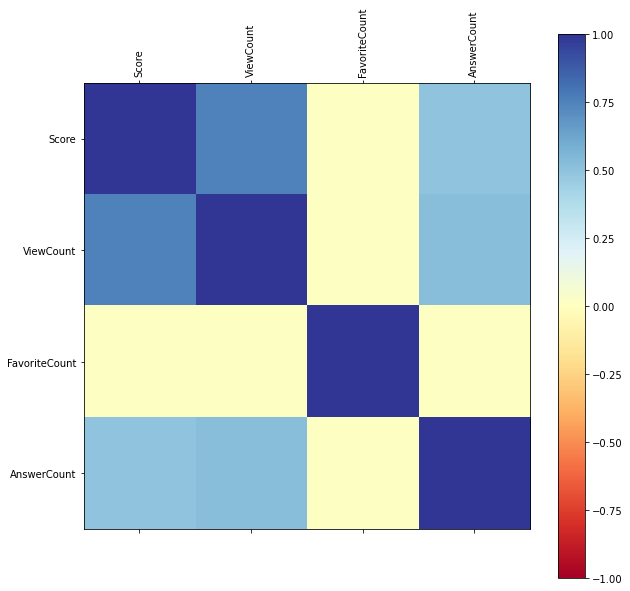

In [12]:
# Function to plot heatmap
correlationMatrix(Stack_exchange_data.drop(['Id'],axis=1))
# Id is not chronoligically assigned, could be correlated to other things

In [13]:
# Discard statistically correlated variables
Stack_exchange_data.drop(['Score', 'ViewCount'], axis=1, inplace=True)
Stack_exchange_data.describe()

,Id,FavoriteCount,AnswerCount
count,4.336900e+04,43369.000000,43369.000000
mean,2.136268e+07,0.000138,4.013489
std,1.877080e+07,0.011761,4.273133
min,4.000000e+00,0.000000,1.000000
25%,4.314804e+06,0.000000,2.000000
50%,1.690978e+07,0.000000,3.000000
75%,3.699008e+07,0.000000,5.000000
max,7.401260e+07,1.000000,126.000000


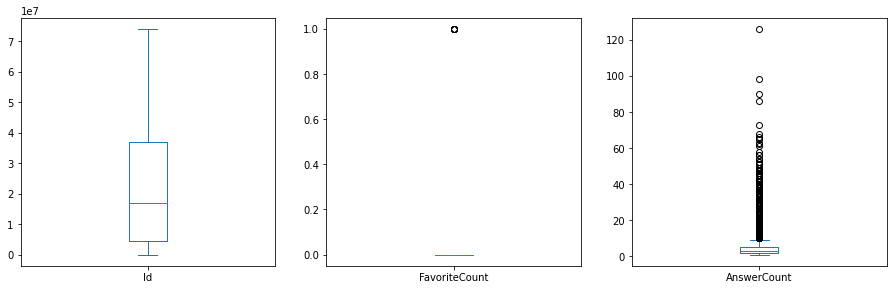

In [14]:
boxPlotAll(Stack_exchange_data)

{'whiskers': [<matplotlib.lines.Line2D at 0x16b0a70d0>,
 'caps': [<matplotlib.lines.Line2D at 0x16b0b4350>,
 'boxes': [<matplotlib.lines.Line2D at 0x16b08f550>],
 'medians': [<matplotlib.lines.Line2D at 0x16b0b51d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x16b0b5a50>],
 'means': []}

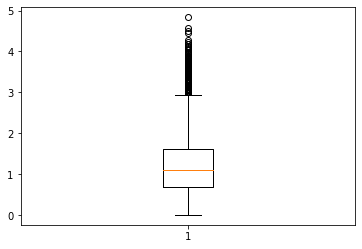

In [15]:
plt.boxplot(np.log(Stack_exchange_data['AnswerCount']))

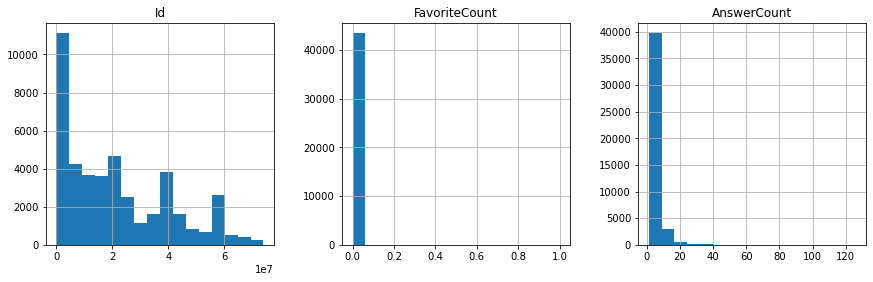

In [18]:
histplotall(Stack_exchange_data)

(array([9.158e+03, 9.785e+03, 1.238e+04, 5.799e+03, 4.357e+03, 1.269e+03,
        4.320e+02, 1.620e+02, 2.300e+01, 4.000e+00]),
 array([0.        , 0.48362819, 0.96725638, 1.45088457, 1.93451276,
        2.41814095, 2.90176914, 3.38539733, 3.86902553, 4.35265372,
        4.83628191]),
 <BarContainer object of 10 artists>)

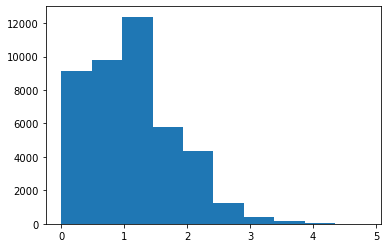

In [25]:
plt.hist(np.log(Stack_exchange_data['AnswerCount']))

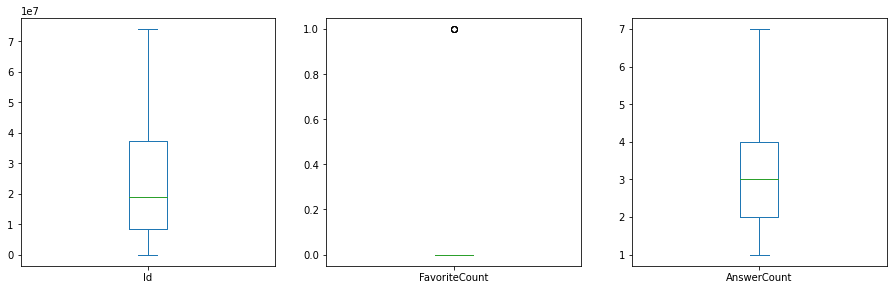

In [16]:
boxPlotAll(Stack_exchange_data[Stack_exchange_data['AnswerCount']<8])

In [17]:
len(Stack_exchange_data[Stack_exchange_data['AnswerCount']<8])/len(Stack_exchange_data)*100

89.0866748138071

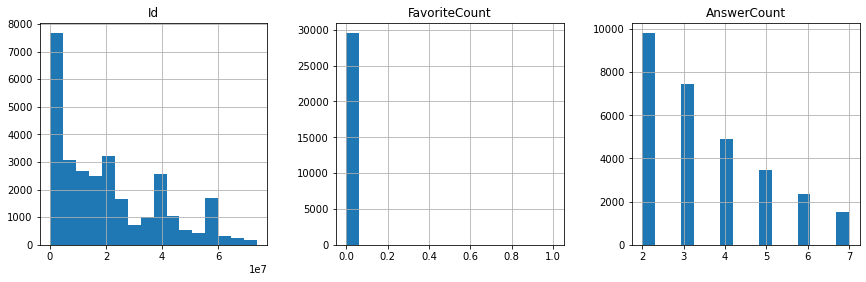

In [26]:
histplotall(Stack_exchange_data[(Stack_exchange_data['AnswerCount']<8) &
                               (Stack_exchange_data['AnswerCount']>1)]  ) 
# pour se debarasser des outliers, il suffit de considerer AnswerCount<8

Stack_exchange_data.info()

In [29]:
gaus_data = (Stack_exchange_data[Stack_exchange_data['AnswerCount']< 8]).copy()

#(Stack_exchange_data[(Stack_exchange_data['AnswerCount']<8) &
                               #(Stack_exchange_data['AnswerCount']>1)]).copy()
print(gaus_data.shape)
gaus_data.head()

(38636, 6)


,Title,Body,Tags,Id,FavoriteCount,AnswerCount
0,Get content of span,<p>how can I get the contents of span ?\nI'm l...,<javascript><jquery><html><forms><contentedita...,20875775,0.0,5
1,VS 2010 configuration transformation produces ...,<p>I use the new VS 2010 configuration transfo...,<asp.net><visual-studio-2010><deployment><conf...,3300210,0.0,3
2,swift: reload view for displaying new data in ...,"<p>im using the chart-framework 'Charts', howe...",<ios><swift><view><charts><reload>,39227530,0.0,1
4,different validation in drf serializer per req...,<p>Lets say i have a model like so:</p>\n\n<pr...,<python><django><validation><serialization><dj...,38170972,0.0,1
6,Recommended SQL database design for tags or ta...,<p>I've heard of a few ways to implement taggi...,<sql><database-design><tags><data-modeling><ta...,20856,1.0,6


In [30]:
gaus_data.describe()

,Id,FavoriteCount,AnswerCount
count,3.863600e+04,38636.000000,38636.000000
mean,2.254815e+07,0.000104,2.917435
std,1.874424e+07,0.010175,1.688814
min,1.290000e+02,0.000000,1.000000
25%,8.242792e+06,0.000000,2.000000
50%,1.889936e+07,0.000000,3.000000
75%,3.727010e+07,0.000000,4.000000
max,7.401260e+07,1.000000,7.000000


First selection is based on a gaussian distribution of data w/o outliers. Second selection would be on tags sparsity --> need cleaning first

## Prepare data

In [31]:
# GET RID OF ALL LINE-RETURNS IN TEXT
def strip_patterns(test):
    formatted_text = test
    for pattern in ['\n']:
        formatted_text = formatted_text.replace(pattern, "")
    return formatted_text
# ------------------------ #
# CLEAN TEXT FROM HTML FORMATTING
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext
# ------------------------ # 
# CLEAN TAGS COLUMN
def tag_words(tag_row):
    tag1= tag_row.replace("<", "").split(">")
    tag1.remove("")
    return tag1

In [32]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
                                       and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

## Clean data

In [33]:
# CLEAN HTML
gaus_data.loc[:, 'Body'] = gaus_data['Body'].apply(lambda x: cleanhtml(x)).apply(lambda x: strip_patterns(x))
gaus_data.loc[:, 'Title'] = gaus_data['Title'].apply(lambda x: cleanhtml(x)).apply(lambda x: strip_patterns(x))
gaus_data.loc[:, ['Body', 'Title']]


,Body,Title
0,how can I get the contents of span ?I'm lookin...,Get content of span
1,I use the new VS 2010 configuration transforma...,VS 2010 configuration transformation produces ...
2,"im using the chart-framework 'Charts', however...",swift: reload view for displaying new data in ...
4,Lets say i have a model like so:class MyModel(...,different validation in drf serializer per req...
6,I've heard of a few ways to implement tagging;...,Recommended SQL database design for tags or ta...
...,...,...
49993,flask_cache.Cache.memoize not working with fla...,Flask cache memoize not working with flask res...
49995,"Since Python has some issues with GIL, Java is...",Why Python is not better in multiprocessing or...
49996,I'm trying to use Allure-framework to generate...,Allure report: nothing shown in Chrome
49997,Recently I came across a bug/feature in severa...,int((0.1+0.7)*10) = 7 in several languages. Ho...


In [48]:
gaus_data['Title_bow'] = gaus_data['Title'].apply(lambda x : transform_bow_fct(x))
gaus_data.loc[:,'Body_bow'] = gaus_data['Body'].apply(lambda x : transform_bow_fct(x))
gaus_data.loc[:, 'Body_bow_lem'] = gaus_data['Body_bow'].apply(lambda x : transform_bow_lem_fct(x))
gaus_data['Title_bow_lem'] = gaus_data['Title_bow'].apply(lambda x : transform_bow_lem_fct(x))
print(gaus_data.shape)
gaus_data.head()

(38636, 13)


,Title,Body,Tags,Id,FavoriteCount,AnswerCount,Tags_words,unique_commn_tag,unique_rare_tag,Title_bow,Body_bow,Body_bow_lem,Title_bow_lem
0,Get content of span,how can I get the contents of span ?I'm lookin...,<javascript><jquery><html><forms><contentedita...,20875775,0.0,5,"[javascript, jquery, html, forms, contentedita...",javascript,contenteditable,get content span,get contents span looking way vanilla jqueryja...,get content span looking way vanilla jqueryjav...,get content span
1,VS 2010 configuration transformation produces ...,I use the new VS 2010 configuration transforma...,<asp.net><visual-studio-2010><deployment><conf...,3300210,0.0,3,"[asp.net, visual-studio-2010, deployment, conf...",asp.net,web-config,2010 configuration transformation produces unw...,use new 2010 configuration transformations dep...,use new 2010 configuration transformation depl...,2010 configuration transformation produce unwa...
2,swift: reload view for displaying new data in ...,"im using the chart-framework 'Charts', however...",<ios><swift><view><charts><reload>,39227530,0.0,1,"[ios, swift, view, charts, reload]",ios,reload,swift reload view displaying new data chart,using chart framework 'charts however reload f...,using chart framework 'charts however reload f...,swift reload view displaying new data chart
4,different validation in drf serializer per req...,Lets say i have a model like so:class MyModel(...,<python><django><validation><serialization><dj...,38170972,0.0,1,"[python, django, validation, serialization, dj...",python,django-rest-framework,different validation drf serializer per reques...,lets say model like class mymodel models.model...,let say model like class mymodel models.model ...,different validation drf serializer per reques...
6,Recommended SQL database design for tags or ta...,I've heard of a few ways to implement tagging;...,<sql><database-design><tags><data-modeling><ta...,20856,1.0,6,"[sql, database-design, tags, data-modeling, ta...",sql,tagging,recommended sql database design tags tagging,'ve heard ways implement tagging using mapping...,'ve heard way implement tagging using mapping ...,recommended sql database design tag tagging


In [50]:
gaus_data.loc[0, 'Body_bow_lem']

"get content span looking way vanilla jqueryjavascript little jquery var swear_words_arr=new array bad evil freak var regex new regexp '\\\\b swear_words_arr.join \\\\b function validate_user_text var text document.getelementbyid 'myinput text.text regex.test text window.location= www.newlocation.com return false var myvar=setinterval function validate_user_text ,1000 changehere html div id= textarea span id= myinput contenteditable= true kfjdkfj span div form name= form1 method= post action= textarea rows= cols= name= user_text style= border:2 solid 808080 font family verdana arial helvetica font weight normal font size:10pt onclick= select_area textarea input type= button value= submit onclick= return validate_user_text form thank"

In [34]:
# CLEAN TAGS HTML FORMATTING
gaus_data['Tags_words'] = ''
gaus_data.loc[:, 'Tags_words'] = gaus_data['Tags'].apply(lambda x: tag_words(x))
gaus_data.head()

,Title,Body,Tags,Id,FavoriteCount,AnswerCount,Tags_words
0,Get content of span,how can I get the contents of span ?I'm lookin...,<javascript><jquery><html><forms><contentedita...,20875775,0.0,5,"[javascript, jquery, html, forms, contentedita..."
1,VS 2010 configuration transformation produces ...,I use the new VS 2010 configuration transforma...,<asp.net><visual-studio-2010><deployment><conf...,3300210,0.0,3,"[asp.net, visual-studio-2010, deployment, conf..."
2,swift: reload view for displaying new data in ...,"im using the chart-framework 'Charts', however...",<ios><swift><view><charts><reload>,39227530,0.0,1,"[ios, swift, view, charts, reload]"
4,different validation in drf serializer per req...,Lets say i have a model like so:class MyModel(...,<python><django><validation><serialization><dj...,38170972,0.0,1,"[python, django, validation, serialization, dj..."
6,Recommended SQL database design for tags or ta...,I've heard of a few ways to implement tagging;...,<sql><database-design><tags><data-modeling><ta...,20856,1.0,6,"[sql, database-design, tags, data-modeling, ta..."


In [35]:
from collections import Counter

In [39]:
# CREATE A UNIQUE TAG PER QUERY
tags_list = list(gaus_data['Tags_words'].apply(lambda x: set(x)))
# extract each item from the tags' (sub) list for each query
flat_list = [item for sublist in tags_list for item in sublist]
# prendre le premier 'for', item in tags list , for each item of the sublist , get item
most_common_tags = [item[0] for item in Counter(flat_list).most_common()]
# each item in Counter is a list of tuple, take first element of the tuple #
most_common_tags

['c#',
 'java',
 'python',
 'javascript',
 'c++',
 'ios',
 'android',
 '.net',
 'html',
 'php',
 'objective-c',
 'jquery',
 'iphone',
 'c',
 'asp.net',
 'linux',
 'css',
 'sql',
 'node.js',
 'spring',
 'performance',
 'ruby-on-rails',
 'xcode',
 'swift',
 'windows',
 'multithreading',
 'mysql',
 'asp.net-mvc',
 'json',
 'ruby',
 'django',
 'macos',
 'unit-testing',
 'wpf',
 'c++11',
 'sql-server',
 'arrays',
 'database',
 'reactjs',
 'algorithm',
 'visual-studio',
 'string',
 'python-3.x',
 'gcc',
 'spring-boot',
 'r',
 'ajax',
 'xml',
 'postgresql',
 'angularjs',
 'hibernate',
 'eclipse',
 'image',
 'numpy',
 'rest',
 'git',
 'angular',
 'pandas',
 'security',
 'cocoa-touch',
 'debugging',
 'authentication',
 'typescript',
 'google-chrome',
 'amazon-web-services',
 'entity-framework',
 'bash',
 'templates',
 'winforms',
 'http',
 'testing',
 'maven',
 'cocoa',
 'scala',
 'jpa',
 'qt',
 'docker',
 'linq',
 'asp.net-core',
 'shell',
 'web-services',
 'optimization',
 'assembly',
 'pytho

In [40]:
tags_list

[{'contenteditable', 'forms', 'html', 'javascript', 'jquery'},
 {'asp.net',
  'configuration',
  'deployment',
  'visual-studio-2010',
  'web-config'},
 {'charts', 'ios', 'reload', 'swift', 'view'},
 {'django', 'django-rest-framework', 'python', 'serialization', 'validation'},
 {'data-modeling', 'database-design', 'sql', 'tagging', 'tags'},
 {'.net', 'c#', 'configuration', 'configurationmanager', 'testing'},
 {'html', 'http', 'https', 'image', 'protocol-relative'},
 {'javascript', 'protractor', 'selenium', 'selenium-webdriver', 'testing'},
 {'ctc', 'deep-learning', 'keras', 'python', 'tensorflow'},
 {'asp.net', 'asp.net-mvc', 'nunit', 'unit-testing', 'visual-studio'},
 {'babeljs', 'javascript', 'module', 'performance', 'webpack'},
 {'.net-2.0', 'c#', 'controls', 'gantt-chart', 'ms-project'},
 {'active-directory', 'authentication', 'coldfusion', 'http', 'ntlm'},
 {'asp.net', 'c#', 'exception', 'mvp', 'n-tier-architecture'},
 {'.net', 'c#', 'configuration', 'configuration-files', 'encryp

In [371]:
len(gaus_data)

38636

In [41]:
# on a besoin de choisir les N tags les plus présents. Ou les N tags qui couvrent 80% des questions pour le ML supervised.
# ----------------------HELPERS-------------------------- #
# METHOD TO CREATE ONE UNIQUE TAG PER 
def most_popular_tag(tags, tags_flat_list):
    index_min_tag = len(most_common_tags)
    min_tag = ''
    for tag in tags:
        if tags_flat_list.index(tag) <= index_min_tag:
            index_min_tag = tags_flat_list.index(tag)
            min_tag = tag
    return min_tag
print(most_popular_tag(tags=['django','python'], tags_flat_list=most_common_tags))

# METHOD TO CREATE ONE UNIQUE TAG PER 
def least_popular_tag(tags, tags_flat_list):
    index_max_tag = 0 #len(most_common_tags)
    max_tag = ''
    for tag in tags:
        if tags_flat_list.index(tag) > index_max_tag:
            index_max_tag = tags_flat_list.index(tag)
            max_tag = tag
    return max_tag

print(least_popular_tag(tags=['android','python'], tags_flat_list=most_common_tags))

python
android


In [42]:
gaus_data.loc[:, 'unique_commn_tag'] = gaus_data['Tags_words'].apply(lambda x: most_popular_tag(x, most_common_tags))
gaus_data.loc[:, 'unique_rare_tag'] = gaus_data['Tags_words'].apply(lambda x: least_popular_tag(x, most_common_tags))
gaus_data

,Title,Body,Tags,Id,FavoriteCount,AnswerCount,Tags_words,unique_commn_tag,unique_rare_tag
0,Get content of span,how can I get the contents of span ?I'm lookin...,<javascript><jquery><html><forms><contentedita...,20875775,0.0,5,"[javascript, jquery, html, forms, contentedita...",javascript,contenteditable
1,VS 2010 configuration transformation produces ...,I use the new VS 2010 configuration transforma...,<asp.net><visual-studio-2010><deployment><conf...,3300210,0.0,3,"[asp.net, visual-studio-2010, deployment, conf...",asp.net,web-config
2,swift: reload view for displaying new data in ...,"im using the chart-framework 'Charts', however...",<ios><swift><view><charts><reload>,39227530,0.0,1,"[ios, swift, view, charts, reload]",ios,reload
4,different validation in drf serializer per req...,Lets say i have a model like so:class MyModel(...,<python><django><validation><serialization><dj...,38170972,0.0,1,"[python, django, validation, serialization, dj...",python,django-rest-framework
6,Recommended SQL database design for tags or ta...,I've heard of a few ways to implement tagging;...,<sql><database-design><tags><data-modeling><ta...,20856,1.0,6,"[sql, database-design, tags, data-modeling, ta...",sql,tagging
...,...,...,...,...,...,...,...,...,...
49993,Flask cache memoize not working with flask res...,flask_cache.Cache.memoize not working with fla...,<python><caching><flask><flask-restful><flask-...,42721927,0.0,4,"[python, caching, flask, flask-restful, flask-...",python,flask-cache
49995,Why Python is not better in multiprocessing or...,"Since Python has some issues with GIL, Java is...",<java><python><multithreading><multiprocessing...,6439061,0.0,2,"[java, python, multithreading, multiprocessing...",java,gil
49996,Allure report: nothing shown in Chrome,I'm trying to use Allure-framework to generate...,<java><maven><webdriver><report><allure>,23997449,0.0,4,"[java, maven, webdriver, report, allure]",java,allure
49997,int((0.1+0.7)*10) = 7 in several languages. Ho...,Recently I came across a bug/feature in severa...,<php><javascript><python><ruby><internal-repre...,6439140,0.0,7,"[php, javascript, python, ruby, internal-repre...",python,internal-representation


In [48]:
gaus_data['Title_bow'] = gaus_data['Title'].apply(lambda x : transform_bow_fct(x))
gaus_data.loc[:,'Body_bow'] = gaus_data['Body'].apply(lambda x : transform_bow_fct(x))
gaus_data.loc[:, 'Body_bow_lem'] = gaus_data['Body_bow'].apply(lambda x : transform_bow_lem_fct(x))
gaus_data['Title_bow_lem'] = gaus_data['Title_bow'].apply(lambda x : transform_bow_lem_fct(x))
print(gaus_data.shape)
gaus_data.head()

(38636, 13)


,Title,Body,Tags,Id,FavoriteCount,AnswerCount,Tags_words,unique_commn_tag,unique_rare_tag,Title_bow,Body_bow,Body_bow_lem,Title_bow_lem
0,Get content of span,how can I get the contents of span ?I'm lookin...,<javascript><jquery><html><forms><contentedita...,20875775,0.0,5,"[javascript, jquery, html, forms, contentedita...",javascript,contenteditable,get content span,get contents span looking way vanilla jqueryja...,get content span looking way vanilla jqueryjav...,get content span
1,VS 2010 configuration transformation produces ...,I use the new VS 2010 configuration transforma...,<asp.net><visual-studio-2010><deployment><conf...,3300210,0.0,3,"[asp.net, visual-studio-2010, deployment, conf...",asp.net,web-config,2010 configuration transformation produces unw...,use new 2010 configuration transformations dep...,use new 2010 configuration transformation depl...,2010 configuration transformation produce unwa...
2,swift: reload view for displaying new data in ...,"im using the chart-framework 'Charts', however...",<ios><swift><view><charts><reload>,39227530,0.0,1,"[ios, swift, view, charts, reload]",ios,reload,swift reload view displaying new data chart,using chart framework 'charts however reload f...,using chart framework 'charts however reload f...,swift reload view displaying new data chart
4,different validation in drf serializer per req...,Lets say i have a model like so:class MyModel(...,<python><django><validation><serialization><dj...,38170972,0.0,1,"[python, django, validation, serialization, dj...",python,django-rest-framework,different validation drf serializer per reques...,lets say model like class mymodel models.model...,let say model like class mymodel models.model ...,different validation drf serializer per reques...
6,Recommended SQL database design for tags or ta...,I've heard of a few ways to implement tagging;...,<sql><database-design><tags><data-modeling><ta...,20856,1.0,6,"[sql, database-design, tags, data-modeling, ta...",sql,tagging,recommended sql database design tags tagging,'ve heard ways implement tagging using mapping...,'ve heard way implement tagging using mapping ...,recommended sql database design tag tagging


In [50]:
gaus_data.loc[0, 'Body_bow_lem']

"get content span looking way vanilla jqueryjavascript little jquery var swear_words_arr=new array bad evil freak var regex new regexp '\\\\b swear_words_arr.join \\\\b function validate_user_text var text document.getelementbyid 'myinput text.text regex.test text window.location= www.newlocation.com return false var myvar=setinterval function validate_user_text ,1000 changehere html div id= textarea span id= myinput contenteditable= true kfjdkfj span div form name= form1 method= post action= textarea rows= cols= name= user_text style= border:2 solid 808080 font family verdana arial helvetica font weight normal font size:10pt onclick= select_area textarea input type= button value= submit onclick= return validate_user_text form thank"

## CREATE TARGET FOR CLASSIFICATION MODELS


0    4717
1    4448
2    3784
3    3457
4    2873
Name: count, dtype: int64


<BarContainer object of 696 artists>

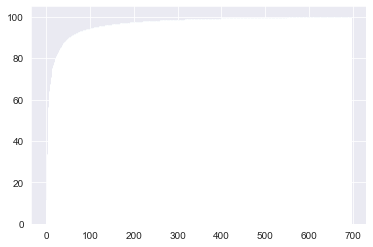

In [409]:
cmmn_tags_df = pd.DataFrame(gaus_data['unique_commn_tag'].value_counts().reset_index())
print(cmmn_tags_df['count'].head())
cmmn_tags_df['cumulated_data'] = np.round(np.cumsum(cmmn_tags_df['count'].values*100/len(gaus_data)), 2)
plt.bar(cmmn_tags_df['cumulated_data'].keys(), cmmn_tags_df['cumulated_data'].values)

In [349]:
def trial_1(x_row):
    return np.where(x_row in N_tags[:], x_row, 'NaN')

In [358]:
#gaus_data.loc[:, 'unique_tag'] = 
gaus_data['unique_tag'] = gaus_data['unique_commn_tag'].apply(lambda x: trial_1(x))
gaus_data['unique_tag'].nunique()

23

In [382]:
#len(gaus_data.drop(gaus_data[gaus_data['unique_tag']=='0'].index, axis=0))
Multiclass_data_80pcent_tags = gaus_data.drop(gaus_data[gaus_data['unique_tag']=='0'].index, axis=0)
Multiclass_data_80pcent_tags.describe()
print(Multiclass_data_80pcent_tags.info())

<class 'pandas.core.frame.DataFrame'>
Index: 30894 entries, 0 to 49998
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             30894 non-null  object 
 1   Body              30894 non-null  object 
 2   Tags              30894 non-null  object 
 3   Id                30894 non-null  int64  
 4   FavoriteCount     30894 non-null  float64
 5   AnswerCount       30894 non-null  int64  
 6   Tags_words        30894 non-null  object 
 7   unique_commn_tag  30894 non-null  object 
 8   unique_rare_tag   30894 non-null  object 
 9   Title_bow         30894 non-null  object 
 10  Body_bow          30894 non-null  object 
 11  Body_bow_lem      30894 non-null  object 
 12  Title_bow_lem     30894 non-null  object 
 13  unique_tag        30894 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 3.5+ MB
None


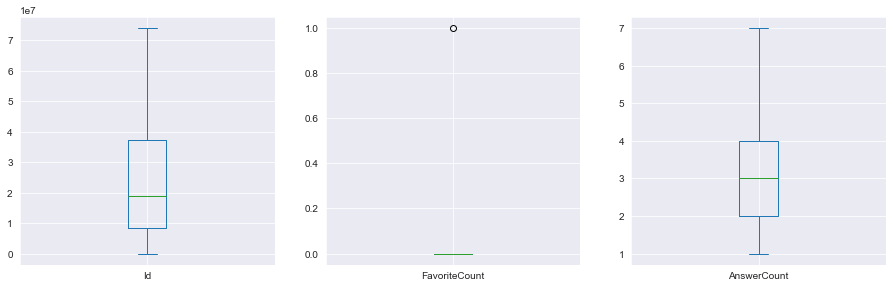

In [377]:
boxPlotAll(Multiclass_data_80pcent_tags.loc[::10, :])

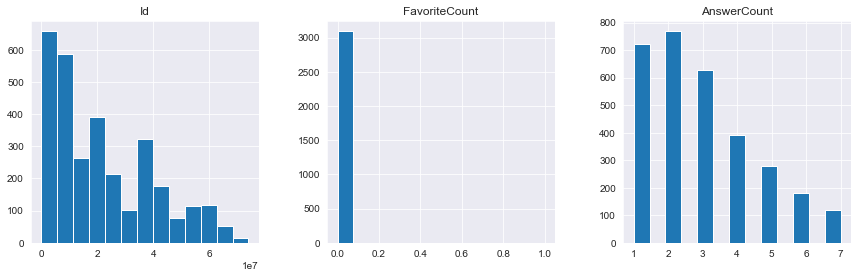

In [378]:
histplotall(Multiclass_data_80pcent_tags.loc[::10, :])

In [390]:
# Check that all unique tags frm N_tags are present in reduced matrix
print((Multiclass_data_80pcent_tags.loc[::10, 'unique_tag']).nunique())
len(Multiclass_data_80pcent_tags.loc[::10, 'unique_tag'])

22


3090

In [405]:
Multiclass_data_80pcent_tags['concatenated_query_bow_lem'] = Multiclass_data_80pcent_tags['Title_bow_lem'] + " " + Multiclass_data_80pcent_tags['Body_bow_lem'] 
Multiclass_data_80pcent_tags.head()

Multiclass_data_80pcent_tags.loc[0, 'concatenated_query_bow_lem']

"get content span get content span looking way vanilla jqueryjavascript little jquery var swear_words_arr=new array bad evil freak var regex new regexp '\\\\b swear_words_arr.join \\\\b function validate_user_text var text document.getelementbyid 'myinput text.text regex.test text window.location= www.newlocation.com return false var myvar=setinterval function validate_user_text ,1000 changehere html div id= textarea span id= myinput contenteditable= true kfjdkfj span div form name= form1 method= post action= textarea rows= cols= name= user_text style= border:2 solid 808080 font family verdana arial helvetica font weight normal font size:10pt onclick= select_area textarea input type= button value= submit onclick= return validate_user_text form thank"

In [406]:
Multiclass_data_80pcent_tags.drop(columns=['Title','Body','Tags', 'Id', 'FavoriteCount'], axis=1, inplace=True)

In [408]:
Multiclass_data_80pcent_tags.to_csv(path_to_file+"Multiclass_data_80pcent_tags.csv")

Multiclass_data_80pcent_tags.loc[::10, :].to_csv(path_to_file+"REDUCED_Multiclass_data_80pcent_tags.csv")


In [323]:
# Get all the tags describing 90% of initial (gaus_data) dataframe for classification models!
N_tags = (list(cmmn_tags_df[cmmn_tags_df['cumulated_data']<=80]['unique_commn_tag']))
#N_tags
len(N_tags)

22

In [324]:
N_tags

['c#',
 'java',
 'python',
 'javascript',
 'c++',
 'ios',
 'android',
 'php',
 'c',
 'sql',
 'ruby-on-rails',
 '.net',
 'html',
 'objective-c',
 'linux',
 'node.js',
 'r',
 'asp.net',
 'jquery',
 'git',
 'windows',
 'iphone']

0    39
1    31
2    29
3    29
4    24
Name: count, dtype: int64


<BarContainer object of 15295 artists>

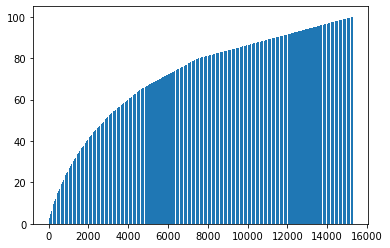

In [46]:
rare_tags_df = pd.DataFrame(gaus_data['unique_rare_tag'].value_counts().reset_index())
print(rare_tags_df['count'].head())
rare_tags_df['cumulated_data'] = np.round(np.cumsum(rare_tags_df['count'].values*100/len(gaus_data)), 2)
plt.bar(rare_tags_df['cumulated_data'].keys(), rare_tags_df['cumulated_data'].values)
      #gaus_data['unique_rare_tag'].value_counts())
#histplotall((cmmn_tags_df), 'Most common tags dist')


In [325]:
# Get all the tags describing 90% of iitial (gaus_data) dataframe
len(list(rare_tags_df[rare_tags_df['cumulated_data']< 10]['unique_rare_tag']))
# len((list(cmmn_tags_df[cmmn_tags_df['cumulated_data']<=90]['unique_commn_tag'])) = 55)

268

In [320]:
N_rare_tags = (list(rare_tags_df[rare_tags_df['cumulated_data']<5]['unique_rare_tag']))
len(N_rare_tags)

109

In [47]:
print(rare_tags_df.head())
print(cmmn_tags_df.head())


    unique_rare_tag  count  cumulated_data
0             razor     39            0.10
1       spring-data     31            0.18
2          eloquent     29            0.26
3              ajax     29            0.33
4  asp.net-core-mvc     24            0.39
  unique_commn_tag  count  cumulated_data
0               c#   4717           12.21
1             java   4448           23.72
2           python   3784           33.52
3       javascript   3457           42.46
4              c++   2873           49.90


In [82]:
# RE-SHUFFLE DATA
shuffled_gaus_data = (gaus_data.sample(frac = 1)).copy()
shuffled_gaus_data.head()

,Title,Body,Tags,Id,FavoriteCount,AnswerCount,Tags_words,unique_commn_tag,unique_rare_tag,Title_bow,Body_bow,Body_bow_lem,Title_bow_lem
1144,"104, 'Connection reset by peer' socket error, ...",We're developing a Python web service and a cl...,<python><sockets><wsgi><httplib2><werkzeug>,383738,0.0,4,"[python, sockets, wsgi, httplib2, werkzeug]",python,httplib2,104 'connection reset peer socket error when c...,'re developing python web service client web s...,'re developing python web service client web s...,104 'connection reset peer socket error closin...
14423,Why is T&& instantiated as int&?,Can anyone please explain why this compiles an...,<c++><templates><c++11><forwarding><rvalue-ref...,4327730,0.0,2,"[c++, templates, c++11, forwarding, rvalue-ref...",c++,forwarding,why instantiated int,can anyone please explain compiles end type in...,anyone please explain compiles end type int am...,instantiated int
16372,What is the best way to unit test a EJB3 compo...,I would like to have a JUnit (or other) system...,<java><jakarta-ee><mocking><ejb-3.0><maven-plu...,553031,0.0,2,"[java, jakarta-ee, mocking, ejb-3.0, maven-plu...",java,ejb-3.0,what best way unit test ejb3 component without...,would like junit system enterprise beans teste...,would like junit system enterprise bean tested...,best way unit test ejb3 component without depl...
49487,Is it possible to audit multiple pages with Ch...,I am trying to find out unused CSS class in my...,<css><google-chrome><google-chrome-extension><...,42685819,0.0,4,"[css, google-chrome, google-chrome-extension, ...",css,developer-tools,possible audit multiple pages chrome developer...,trying find unused css class website found aud...,trying find unused cs class website found audi...,possible audit multiple page chrome developer ...
26269,Initialize unordered_map in the initializer list,I'm trying to find a solution to what may be a...,<c++><c++11><initialization><c++14><unordered-...,44641395,0.0,2,"[c++, c++11, initialization, c++14, unordered-...",c++,unordered-map,initialize unordered_map initializer list,trying find solution may trivial problem would...,trying find solution may trivial problem would...,initialize unordered_map initializer list


In [83]:
shuffled_gaus_data.drop(columns=['Title','Body','Tags', 'Id', 'FavoriteCount'], axis=1, inplace=True)

In [90]:
print(shuffled_gaus_data.iloc[::2].info())
print(shuffled_gaus_data.loc[::2].info())

<class 'pandas.core.frame.DataFrame'>
Index: 19318 entries, 1144 to 3595
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   AnswerCount       19318 non-null  int64 
 1   Tags_words        19318 non-null  object
 2   unique_commn_tag  19318 non-null  object
 3   unique_rare_tag   19318 non-null  object
 4   Title_bow         19318 non-null  object
 5   Body_bow          19318 non-null  object
 6   Body_bow_lem      19318 non-null  object
 7   Title_bow_lem     19318 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 19318 entries, 1144 to 3595
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   AnswerCount       19318 non-null  int64 
 1   Tags_words        19318 non-null  object
 2   unique_commn_tag  19318 non-null  object
 3   unique_rare_tag   19318 non-null  object

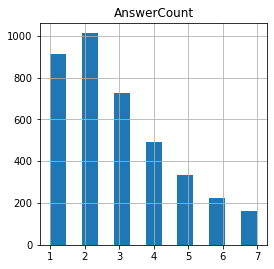

In [94]:
histplotall(shuffled_gaus_data.loc[::10])

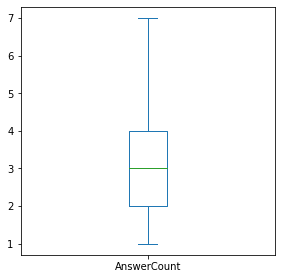

In [95]:
boxPlotAll(shuffled_gaus_data.iloc[::10])

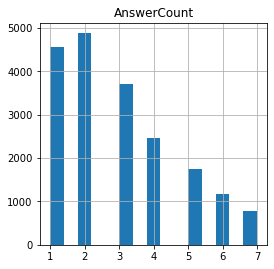

In [88]:
histplotall(shuffled_gaus_data.iloc[::2])

In [96]:
print(len(shuffled_gaus_data.iloc[::10]))
print(len(shuffled_gaus_data.loc[::2]))


3864
19318


## Create data for unsupervised models

In [149]:
# DATA TO TEST WORD2VEC
shuffled_data = (shuffled_gaus_data.iloc[::2]).copy()
shuffled_data.loc[:, 'concatenated_query_bow_lem'] = shuffled_data['Title_bow_lem'] + shuffled_data['Body_bow_lem'] 
shuffled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19318 entries, 1144 to 3595
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   AnswerCount                 19318 non-null  int64 
 1   Tags_words                  19318 non-null  object
 2   unique_commn_tag            19318 non-null  object
 3   unique_rare_tag             19318 non-null  object
 4   Title_bow                   19318 non-null  object
 5   Body_bow                    19318 non-null  object
 6   Body_bow_lem                19318 non-null  object
 7   Title_bow_lem               19318 non-null  object
 8   concatenated_query_bow_lem  19318 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.5+ MB


In [108]:
shuffled_data.to_csv(path_to_file+'WORD2VEC_shuffled_data_23052023.csv')

In [410]:
shuffled_data.head()

,AnswerCount,Tags_words,unique_commn_tag,unique_rare_tag,Title_bow,Body_bow,Body_bow_lem,Title_bow_lem,concatenated_query_bow_lem
1144,4,"[python, sockets, wsgi, httplib2, werkzeug]",python,httplib2,104 'connection reset peer socket error when c...,'re developing python web service client web s...,'re developing python web service client web s...,104 'connection reset peer socket error closin...,104 'connection reset peer socket error closin...
16372,2,"[java, jakarta-ee, mocking, ejb-3.0, maven-plu...",java,ejb-3.0,what best way unit test ejb3 component without...,would like junit system enterprise beans teste...,would like junit system enterprise bean tested...,best way unit test ejb3 component without depl...,best way unit test ejb3 component without depl...
26269,2,"[c++, c++11, initialization, c++14, unordered-...",c++,unordered-map,initialize unordered_map initializer list,trying find solution may trivial problem would...,trying find solution may trivial problem would...,initialize unordered_map initializer list,initialize unordered_map initializer listtryin...
10592,1,"[cocoa, macos, document, finder, file-type]",macos,file-type,how make finder 'open with work application xcode,created application capable playing audio file...,created application capable playing audio file...,make finder 'open work application xcode,make finder 'open work application xcodecreate...
35374,3,"[javascript, node.js, npm, webpack, create-rea...",javascript,create-react-app,error version chokidar available tried chokida...,using ejected cra compiles successfully breaks...,using ejected cra compiles successfully break ...,error version chokidar available tried chokida...,error version chokidar available tried chokida...


# LDA
## data preparation for LDA

In [150]:
from sklearn.feature_extraction.text import CountVectorizer
# INSTANCIATE A VECTORIZER
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')


In [151]:
# try #
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
        return final


In [ ]:
data_words = gen_words((shuffled_data.loc[:, 'concatenated_query_bow_lem']).to_list())
print(type(data_words), '\n',data_words[0][:100])

In [153]:
X_train = shuffled_data.loc[:, 'concatenated_query_bow_lem']
sentences = X_train.to_list()

sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [154]:
# Replace data_words with sentences
# FIT THE VECTORIZER
tf = tf_vectorizer.fit_transform(X_train)
tf

<19318x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 674839 stored elements in Compressed Sparse Row format>

In [155]:
# access few different key pieces of data
my_id2word = corpora.Dictionary(sentences)
my_id2word
my_corpus = []
for text in sentences:
    # CREATE A BAG OF WORDS CONTAINING A LIST OF UNIQUE WORDS AND THEIR FREQUENCY
    new = my_id2word.doc2bow(text)
    my_corpus.append(new)
print(my_corpus[0][:10])

[(0, 7), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 4)]


## LDA using sklearn

In [156]:
# CREATE LDA MODEL
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 10
# ATTENTION! Le nombre de sujets reste un hyperparamètre pour LDA à trouver au préalable
# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [160]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
self value key item array import return 00 index map
Topic 1:
like use using way code time need know want ve
Topic 2:
error lib build file project app version module package js
Topic 3:
java org apache spring springframework com jar dependency version xml
Topic 4:
data table database query model user select sql set test
Topic 5:
string android public class int new return void type private
Topic 6:
quot app user com client server google service token connection
Topic 7:
text view div class html button std image function element
Topic 8:
request thread error response url log post message json web
Topic 9:
file line python image py byte data php path command


## LDA using Gensim and pyLDAvis

In [179]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=my_corpus, id2word=my_id2word, num_topics=9)

## Visualize data

In [411]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, my_corpus, my_id2word, mds="mmds")
vis

/Users/souha_kassab/opt/miniconda3/envs/topicmodel_env/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.056283  0.031631       1        1  21.565316
7      0.021998 -0.053733       2        1  14.262138
6     -0.020276  0.246450       3        1  12.551601
4     -0.200204 -0.095966       4        1  10.010115
1      0.160262 -0.243239       5        1   8.654217
5     -0.133669  0.129980       6        1   8.433563
8     -0.099228 -0.150281       7        1   8.214013
2      0.213256 -0.001991       8        1   8.194656
3      0.114145  0.137150       9        1   8.114381, topic_info=         Term          Freq         Total Category  logprob  loglift
1125     quot  17558.000000  17558.000000  Default  30.0000  30.0000
1105     java  13414.000000  13414.000000  Default  29.0000  29.0000
1022      org   8623.000000   8623.000000  Default  28.0000  28.0000
370   android  10593.000000  10593.000000  Default  27.0000  27.0000
985      self   7038.000000   7038.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
47       like    644.042515  11964.259346   Topic9  -5.7408  -0.4104
154      test    615.069469   7561.207794   Topic9  -5.7868   0.0025
7         app    567.525745   8865.496582   Topic9  -5.8673  -0.2371
270      work    558.722607   8586.174289   Topic9  -5.8829  -0.2207
263       use    555.257408  10805.991694   Topic9  -5.8891  -0.4569

[806 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
21459      2  0.986571   acceleration
3834       4  0.977854   actionscript
29186      8  0.992206  active_record
13059      5  0.988961       activemq
12190      1  0.057995   activerecord
...      ...       ...            ...
1988       8  0.012672            xml
1988       9  0.060194            xml
22263      2  0.983234    xmldocument
51637      7  0.990647            xmm
27155      6  0.985218        zipfile

[3372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 7, 5, 2, 6, 9, 3, 4])

La visu permet de modifier le nombre de topics de sorte à ne pas avoir des clusters avec repliement
Potentially need to get rid of high-frequency terms in order to improve clustering (cluster 1 is connected to 'using', cluster 2 to 'self', etc..)

In [181]:
stop

NameError: name 'stop' is not defined

# K-MEANS CLUSTERING

In [182]:
from sklearn.manifold import TSNE
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA

In [201]:
import time

In [184]:
import seaborn as sns
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
sns.set_style('darkgrid')

In [252]:
def scaling(self):
        self.std_scaler = preprocessing.StandardScaler().fit(self.X)
        self.X_scaled = self.std_scaler.transform(self.X)
        print(np.mean(self.X_scaled))
# --------------------------------- #
        
def plot_silhouette(the_pickle):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    plt.plot(range(the_pickle.min_range, the_pickle.max_range), the_pickle.silhouettes,
             marker='o')
    for xy in zip(range(the_pickle.min_range,the_pickle.max_range), np.around(the_pickle.silhouettes,2)):                                      
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.xlabel('Number of clusters')
    plt.ylabel ('Coef. de silhouette')
    plt.show()
# --------------------------------- #

# FUNCTION TO LOAD AND RETRIEVE METRICS
def load_pickle(pickle_name):
    # PICKLE_NAME MUST BE GIVEN BETWEEN "QUOTATIONS" AND WITH THE PROPER EXTENSION .P
    the_pickle = pickle.load(open(pickle_name, "rb" ))
    print(the_pickle.features)
    plot_silhouette(the_pickle)
    sum_of_squared_distances = []
    K = range(2,16)
    for k in K:
        model = cluster.KMeans(n_clusters=k, n_init=1).fit(the_pickle.X_scaled[::10, :])
        sum_of_squared_distances.append(model.inertia_)

    plt.plot(K, sum_of_squared_distances, "bx-")
    plt.xlabel("“K values”")
    plt.ylabel("“Sum of Squared Distances”")
    plt.title("“Elbow Method”")
    plt.show()
    return the_pickle
# -------------------------------------------- #
# FUNCTION TO RUN PCA
def run_pca(X_norm, data_features):
    # CHECK THAT DATA IS PROPERLY SCALED AND CENTERED
    print(np.mean(X_norm),',', np.var(X_norm), ',\n', type(X_norm))
    idx = ["mean", "std"]
    #reduction et centrage
    pd.DataFrame(X_norm).describe().round(2).loc[idx, :]
    # INSTANCIATING A PCA
    pca = PCA(n_components=0.99)
    pca.fit(X_norm)
    # EXPLAINING VARIANCE
    pca.explained_variance_ratio_
    scree = (pca.explained_variance_ratio_*100).round(2)
    print(scree)
    scree_cum = scree.cumsum().round()
    print(scree_cum)
    x_list = range(1, len(scree)+1)
    print(list(x_list))
    # PLOT EBOULIS DES VALEURS PROPRES
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum,c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    # VISUALIZATION
    pcs = pca.components_
 
    return pca

In [186]:
class KClustering:
    def scaling(self):
        self.std_scaler = preprocessing.StandardScaler().fit(self.X)
        self.X_scaled = self.std_scaler.transform(self.X)
        print(np.mean(self.X_scaled))
        # -------------------------------------------------------------- #        
        # Clustering metrics
        # -------------------------------------------------------------- #
        # Plotting inertia versus number of clusters (Elbow method)
    def plot_elbow(self):
        plt.plot(range(self.min_range, self.max_range), self.sum_of_squared_distances, "bx-")
        plt.xlabel("“K values”")
        plt.ylabel("“Sum of Squared Distances”")
        plt.title("“Elbow Method”")
        plt.show()
        # Plotting silhouette variation with number of clusters
    def plot_silhouette(self):
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)
        plt.plot(range(self.min_range, self.max_range), self.silhouettes, marker='o')
        for xy in zip(range(self.min_range,self.max_range), np.around(self.silhouettes,2)):                                      
            ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        plt.xlabel('Number of clusters')
        plt.ylabel ('Coef. de silhouette')
        # -------------------------------------------------------------- #
        # Step_1: Visualize kmeans results 
        # -------------------------------------------------------------- #
    def results_comparison(self):
        # Table to visualize clusters size compared to clustering silhouette (and inertia?)
        self.metrics = pd.DataFrame({
            'Number_of_clusters': pd.Series(self.clusters.keys()),
            'Silhouettes' : pd.Series(self.silhouettes),
            'Clusters_labels' : pd.Series([(np.unique(self.clusters[x], return_counts=True)[0]) for x in self.clusters.keys()]),
            'Clusters_size' :  pd.Series([(np.unique(self.clusters[x], return_counts=True)[1]) for x in self.clusters.keys()])
        })
        
        # -------------------------------------------------------------- #     
    def __repr__(self):
        return f'Clustering: X={self.X}, "\nscores des clusters = {self.silhouettes}"'
        # -------------------------------------------------------------- #     

    def __init__(self, df, min_range, max_range):
        self.min_range = min_range
        self.max_range = max_range
        self.X = df.select_dtypes(exclude=['object']).dropna().values
        #self.X = self.X[::10, :]
        self.features = df.select_dtypes(exclude=['object']).columns
        
        self.sum_of_squared_distances = [] 
        self.silhouettes=[]
        self.clusters = {}
        self.centroids = {}
        max_silhouette = 0
        self.cluster_number_of_max_silhouette = 0
                      
        t1 = time.perf_counter() # Monitor clustering time
        for clusters_number in range(self.min_range, self.max_range):
            print (f'number of clusters =  {clusters_number}')
            clus = cluster.KMeans(n_clusters=clusters_number, n_init=1, init='random')
            clus_model=clus.fit(self.X)
            self.sum_of_squared_distances.append(clus_model.inertia_)
            self.clusters[clusters_number] = clus.labels_
            self.centroids[clusters_number] = clus.cluster_centers_
            sls= metrics.silhouette_score(self.X, clus.labels_)
            if (sls > max_silhouette):
                max_silhouette = sls
                self.cluster_number_of_max_silhouette = clusters_number
            self.silhouettes.append(sls)
        # Monitor clustering time        
        t2 = time.perf_counter()
        print(f"k-means time = {t2-t1} seconds")
        # Get results
        self.plot_elbow()
        self.plot_silhouette()
        self.results_comparison()
        self.scaling()


In [199]:
# display the dense document-term matrix for clustering needs
vocab = tf_vectorizer.get_feature_names_out()
docterm = pd.DataFrame(tf.todense(), columns=vocab)
print(docterm.info() )
docterm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19318 entries, 0 to 19317
Columns: 1000 entries, 00 to zero
dtypes: int64(1000)
memory usage: 147.4 MB
None


,00,000,01,02,08,10,100,1000,103,11,...,www,x86,x86_64,xcode,xml,xmlns,xsd,year,yes,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19314,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


number of clusters =  8
number of clusters =  9
number of clusters =  10
k-means time = 32.35305173101369 seconds


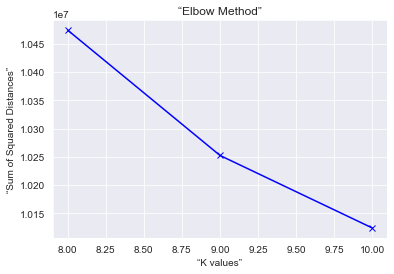

-8.047766362165334e-19


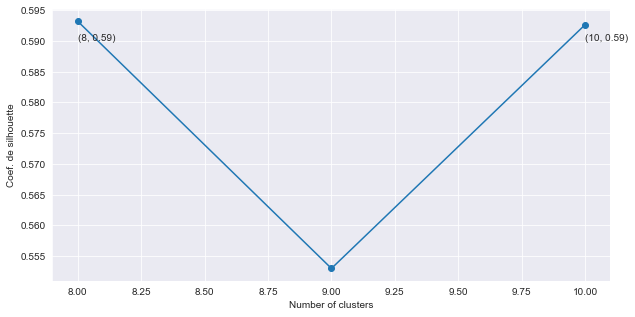

In [202]:
k_clustering_1 = KClustering(docterm, 8, 11)

0.07366502743555234 , 00       4.163152
000      0.118917
01       0.110092
02       0.672695
08       0.883969
           ...   
xmlns    0.248421
xsd      6.599213
year     0.094262
yes      0.197180
zero     0.079371
Length: 1000, dtype: float64 ,
 <class 'pandas.core.frame.DataFrame'>
[2.188e+01 9.710e+00 3.180e+00 2.440e+00 1.990e+00 1.670e+00 1.460e+00
 1.390e+00 1.360e+00 1.180e+00 1.150e+00 1.090e+00 9.800e-01 9.400e-01
 9.200e-01 8.800e-01 8.400e-01 8.200e-01 7.800e-01 7.200e-01 7.000e-01
 6.800e-01 6.600e-01 6.300e-01 5.900e-01 5.600e-01 5.300e-01 5.200e-01
 4.900e-01 4.600e-01 4.500e-01 4.200e-01 4.100e-01 3.900e-01 3.900e-01
 3.800e-01 3.600e-01 3.500e-01 3.400e-01 3.300e-01 3.300e-01 3.200e-01
 3.100e-01 3.100e-01 3.000e-01 2.900e-01 2.900e-01 2.800e-01 2.700e-01
 2.700e-01 2.600e-01 2.600e-01 2.500e-01 2.400e-01 2.400e-01 2.300e-01
 2.300e-01 2.300e-01 2.200e-01 2.200e-01 2.200e-01 2.200e-01 2.100e-01
 2.100e-01 2.000e-01 2.000e-01 2.000e-01 2.000e-01 1.900e-01 1.900e-01


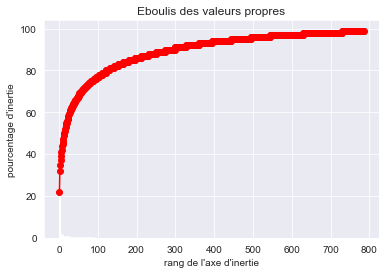

PCA(n_components=0.99)

In [237]:
# WAIT TILL WORD2VEC MODEL IS COMPUTED
run_pca(X_norm=docterm, data_features=vocab)

In [205]:
stop

NameError: name 'stop' is not defined

# WORD2VEC

In [219]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split



## Load a small dataset


In [223]:
small_df = pd.read_csv(path_to_file+'WORD2VEC_shuffled_data_23052023.csv', index_col=[0])
print(small_df.shape)

X_train, X_test, y_train, y_test = train_test_split(small_df['concatenated_query_bow_lem'], 
                                                    small_df['unique_commn_tag'])

(3864, 9)


In [224]:
print(y_train.shape, y_test.shape)

(2898,) (966,)


In [225]:
print(X_train.shape, X_test.shape)

(2898,) (966,)


In [226]:
sentlist_mean = [len(sentences[i]) for i in range(0, len(sentences)-1)]
np.mean(sentlist_mean)

127.22875681645613

## Création du modèle Word2Vec

In [228]:
# train model on OC_P5 small data
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print('Trained model summary:',model)
# summarize vocabulary 
words = list(model.wv.key_to_index.keys())
print('the learned vocabulary of tokens (words):', words)

# the values correspond to the word's index in the model vocabulary generated by Gensim by the use of Word2Vec

Trained model summary: Word2Vec<vocab=31177, vector_size=100, alpha=0.025>
the learned vocabulary of tokens (words): ['quot', 'file', 'using', 'java', 'data', 'class', 'new', 'get', 'error', 'code', 'use', 'string', 'like', 'name', 'public', 'return', 'app', 'org', 'user', 'function', 'would', 'value', 'work', 'android', 'int', 'one', 'com', 'type', 'way', 'test', 'object', 'method', 'version', 'application', 'system', 'self', 'time', 'set', 'run', 'import', 'amp', 'want', 'problem', 'add', 'server', 'line', 'python', 'need', 've', 'project', 'var', 'void', 'example', 'true', 'also', 'lib', 'know', 'request', 'result', 'following', 'text', 'view', 'list', 'create', 'web', 'tried', 'page', 'null', 'build', 'could', 'call', 'question', 'library', 'make', 'image', 'dependency', 'key', 'private', 'this', 'net', 'io', 'find', 'main', 'service', 'py', 'message', 'window', 'something', 'api', 'array', 'log', 'found', 'path', 'exception', 'see', 'client', 'url', 'table', 'id', 'package', 'firs

In [229]:
# access vector for one word
print(model.wv.key_to_index['frame'])
model.wv.key_to_index

379


{'quot': 0,
 'file': 1,
 'using': 2,
 'java': 3,
 'data': 4,
 'class': 5,
 'new': 6,
 'get': 7,
 'error': 8,
 'code': 9,
 'use': 10,
 'string': 11,
 'like': 12,
 'name': 13,
 'public': 14,
 'return': 15,
 'app': 16,
 'org': 17,
 'user': 18,
 'function': 19,
 'would': 20,
 'value': 21,
 'work': 22,
 'android': 23,
 'int': 24,
 'one': 25,
 'com': 26,
 'type': 27,
 'way': 28,
 'test': 29,
 'object': 30,
 'method': 31,
 'version': 32,
 'application': 33,
 'system': 34,
 'self': 35,
 'time': 36,
 'set': 37,
 'run': 38,
 'import': 39,
 'amp': 40,
 'want': 41,
 'problem': 42,
 'add': 43,
 'server': 44,
 'line': 45,
 'python': 46,
 'need': 47,
 've': 48,
 'project': 49,
 'var': 50,
 'void': 51,
 'example': 52,
 'true': 53,
 'also': 54,
 'lib': 55,
 'know': 56,
 'request': 57,
 'result': 58,
 'following': 59,
 'text': 60,
 'view': 61,
 'list': 62,
 'create': 63,
 'web': 64,
 'tried': 65,
 'page': 66,
 'null': 67,
 'build': 68,
 'could': 69,
 'call': 70,
 'question': 71,
 'library': 72,
 'make':

## Plot Word Vectors Using PCA

In [265]:
def scaling(X):
    std_scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scaler.transform(X)
    #print(np.mean(X_scaled), np.var(X_scaled))
    return X_scaled

1.6885147e-09 , 0.9999998 ,
 <class 'numpy.ndarray'>
[47.36 14.7  12.33  7.85  4.13  3.51  2.58  1.9   1.19  1.02  0.71  0.65
  0.35  0.26  0.23  0.15  0.11]
[47. 62. 74. 82. 86. 90. 92. 94. 96. 97. 97. 98. 98. 99. 99. 99. 99.]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


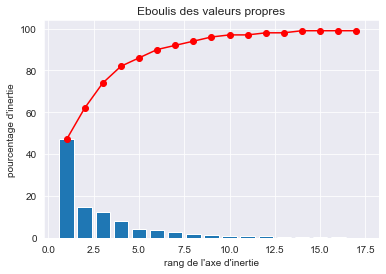

In [267]:
pca = run_pca(X_norm=scaling(model.wv[model.wv.key_to_index.values()]), data_features=model.wv[model.wv.key_to_index.keys()])

In [288]:
pcs = pca.components_
print(pcs.shape)

(17, 100)


Get back the tags, compare with LDA and see if they are the same englobing 80% of data
USE SAME DATASET FOR SUPERVISED AND UNSUPERVISED

In [287]:
print(result.shape)

(31177, 17)


In [ ]:
from matplotlib import pyplot
X = scaling(model.wv[model.wv.key_to_index.values()])
#pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words[:10]):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    # Afficher une ligne horizontale y=0
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    # Afficher une ligne verticale x=0
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
plt.xlabel('F1')
plt.ylabel('F2')
plt.show()
pyplot.show()

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams